# Model Development and Apparent Validation

In [ ]:
source("notebooks/initialize-data-analysis.r")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

# Penalized Likelihood Methods

## Backwards Stepwise Logistic Regression

In [ ]:
# library(StepReg)
# run_stepwise_logit <- function(data, formula) {
#   stepwiseLogit(
#     formula,
#     data = data,
#     include = NULL,
#     selection = "backward",
#     select = "AIC"
#   )
# }

# stepwise_model <- data_patient_complete |>
#   select(all_of(predictor_list), flag_ADR_TP_ID) |>
#   run_stepwise_logit(
#     formula = flag_ADR_TP_ID ~ .
#   )

# stepwise_model |> summary()


In [ ]:
run_step_AIC <- function(data, formula) {
  MASS::stepAIC(
    glm(
      formula = formula,
      data = data
    ),
    direction = "backward",
    trace = FALSE
  )
}

stepwise_model <- data_patient_complete |>
  select(all_of(predictor_list), flag_ADR_TP_ID) |>
  run_step_AIC(
    formula = flag_ADR_TP_ID ~ .
  )

stepwise_model$coefficients |> length()


[1] 17

Results: Stepwise algorithm selected 17 predictors.

## LASSO Variable Selection

In [ ]:
library(glmnet)


Loading required package: Matrix


Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

Loaded glmnet 4.1-8

[1] 26

Results: LASSO algorithm selected 22-25 predictors.

Comment: Penalized likelihood methods have comparable predictive performance to Bayesian methods \[citation needed\], but select many more predictors.

# Bayesian Model Selection

                         P(B != 0 | Y)      model 1      model 2   model 3
Intercept                  1.000000000    1.0000000    1.0000000    1.0000
patient_age                0.772055834    1.0000000    1.0000000    1.0000
patient_sexTRUE            0.004590631    0.0000000    0.0000000    0.0000
LZD_dose_per_weight        0.004120517    0.0000000    0.0000000    0.0000
baseline_CLCR              0.332261533    0.0000000    0.0000000    0.0000
dept_ERTRUE                0.003979028    0.0000000    0.0000000    0.0000
dept_ICUTRUE               0.009495155    0.0000000    0.0000000    0.0000
baseline_HGB               0.267257026    0.0000000    0.0000000    1.0000
baseline_WBC               0.005744037    0.0000000    0.0000000    0.0000
baseline_PLT               1.000000000    1.0000000    1.0000000    1.0000
LZD_duration               0.999497401    1.0000000    1.0000000    1.0000
invasive_ETITRUE           0.110917171    0.0000000    0.0000000    0.0000
invasive_CVCTRUE         

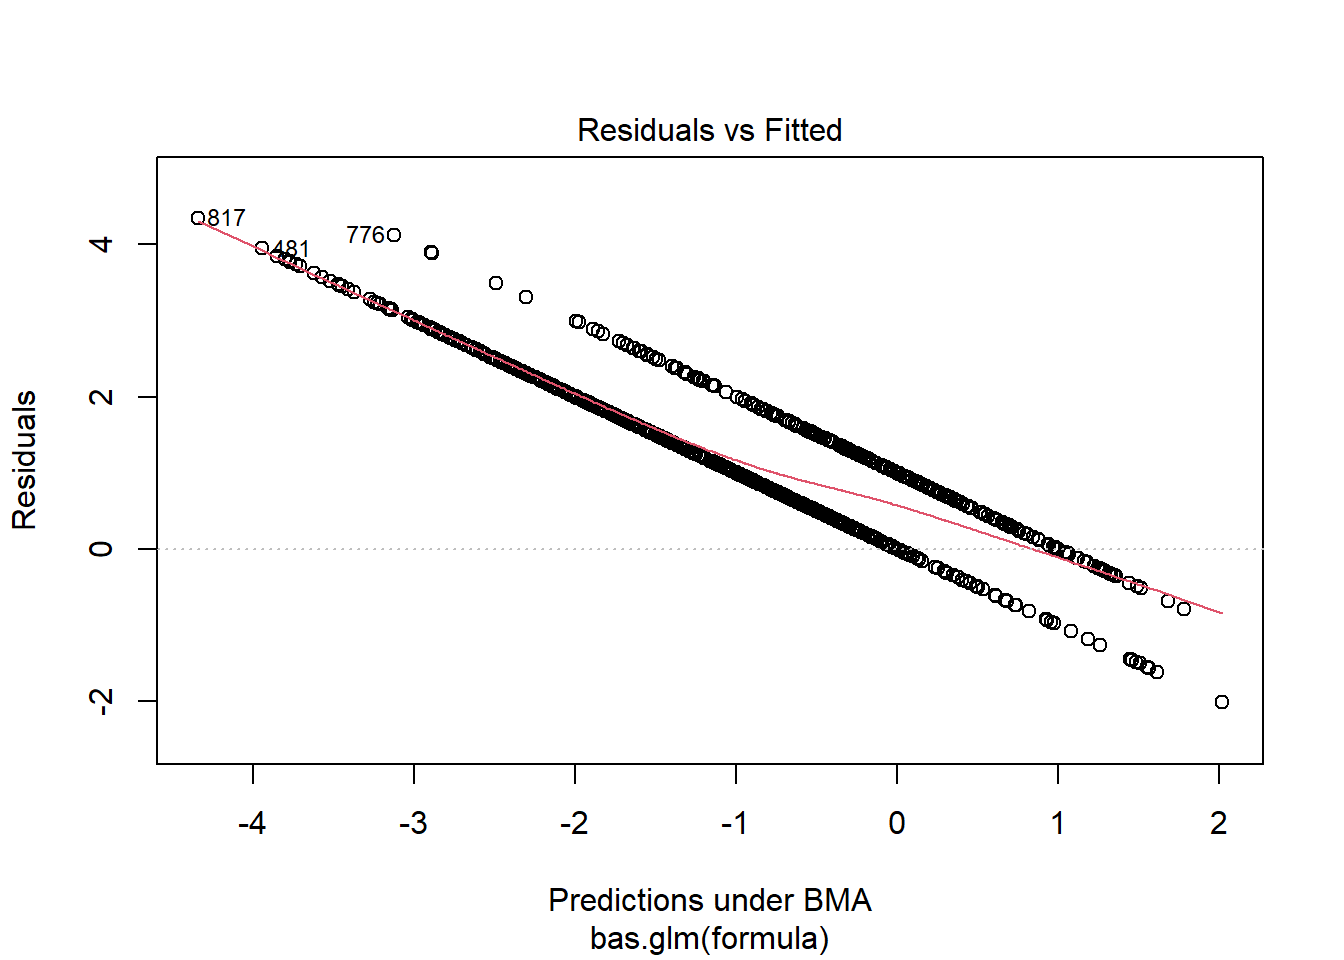

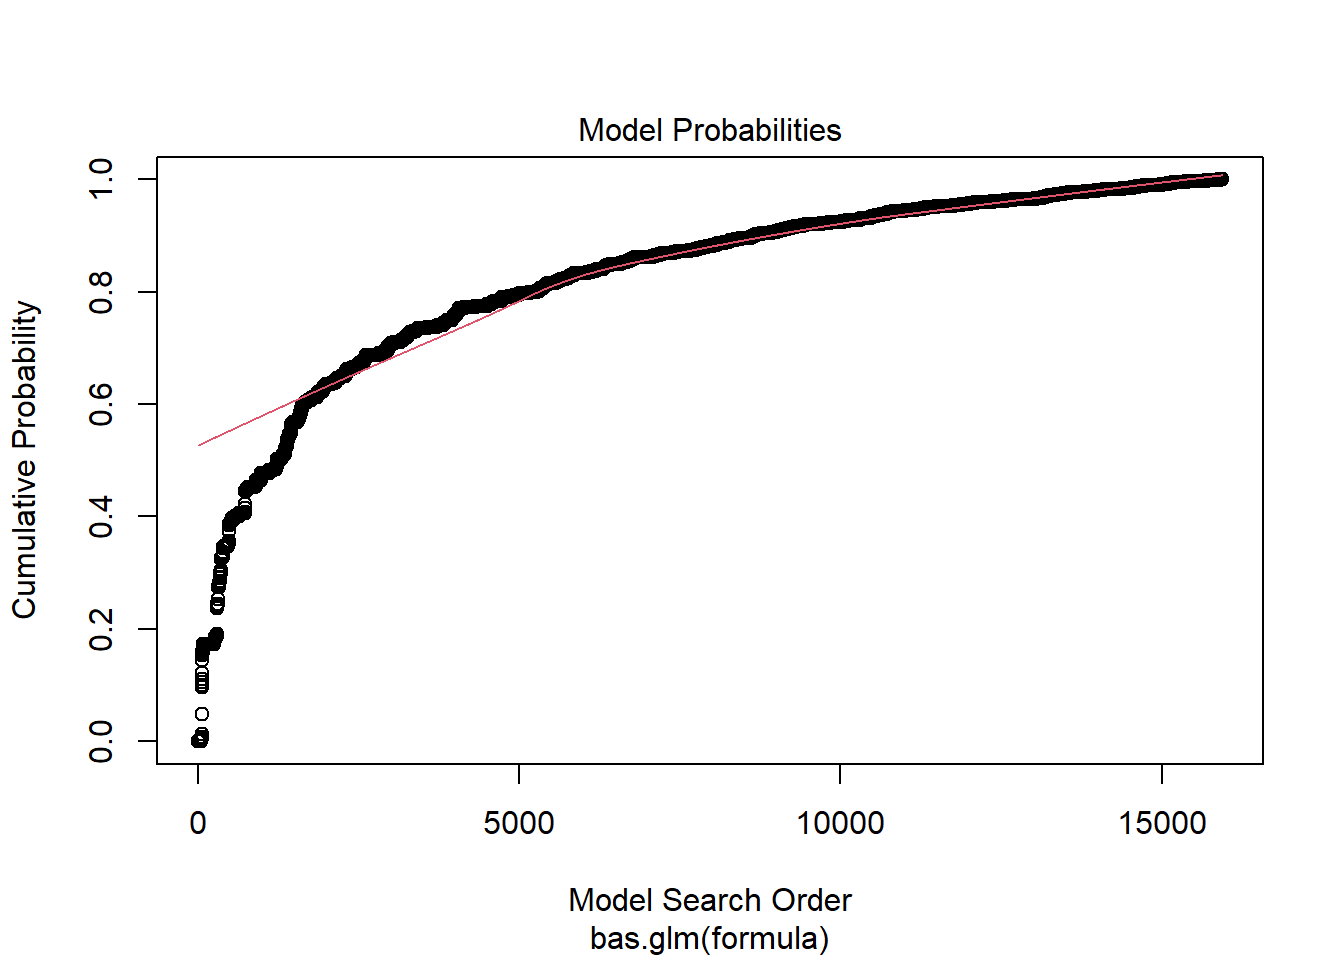

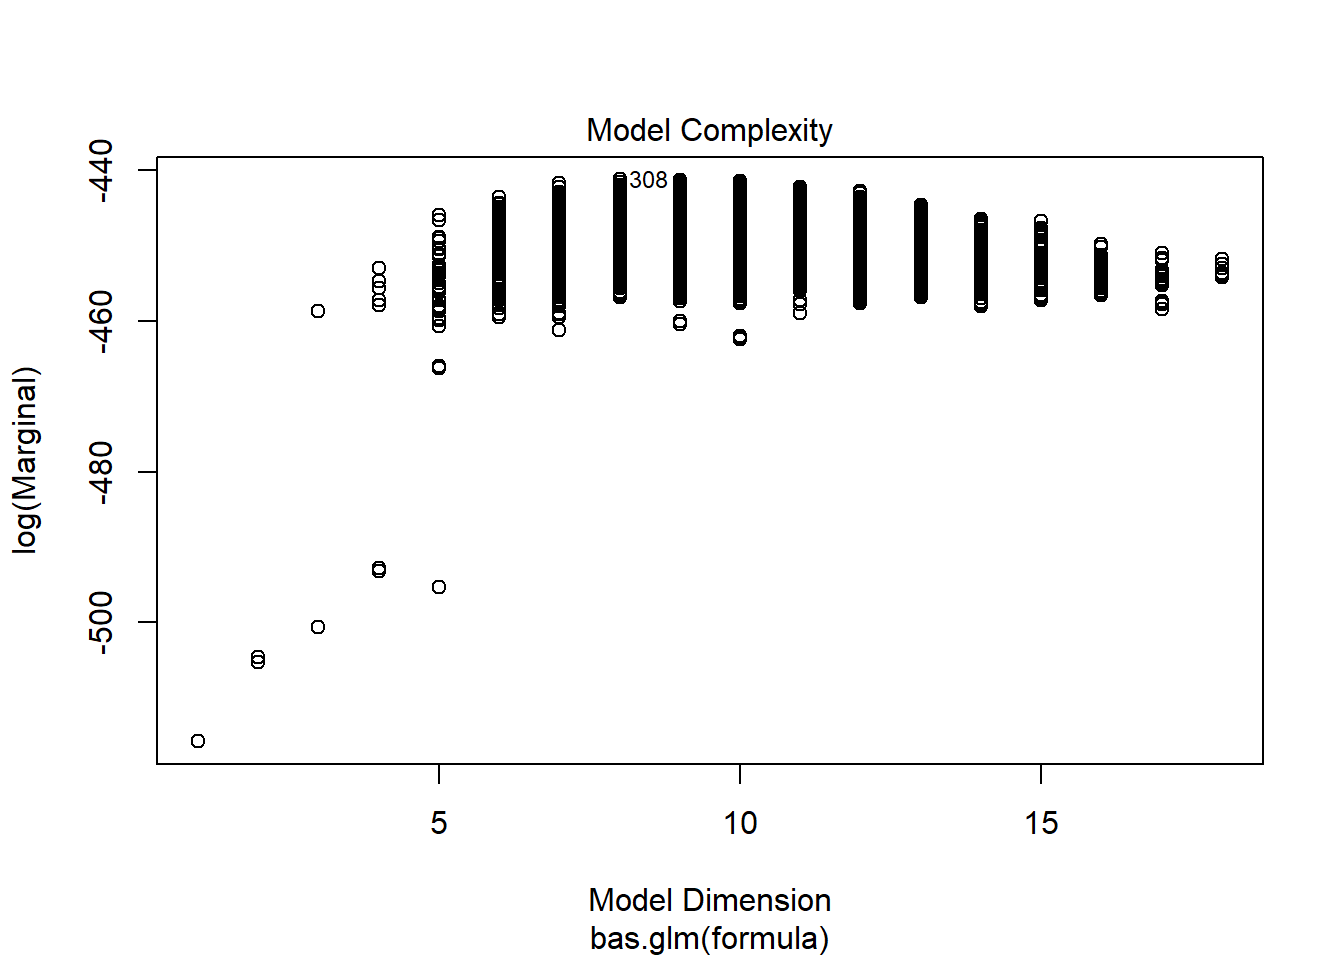

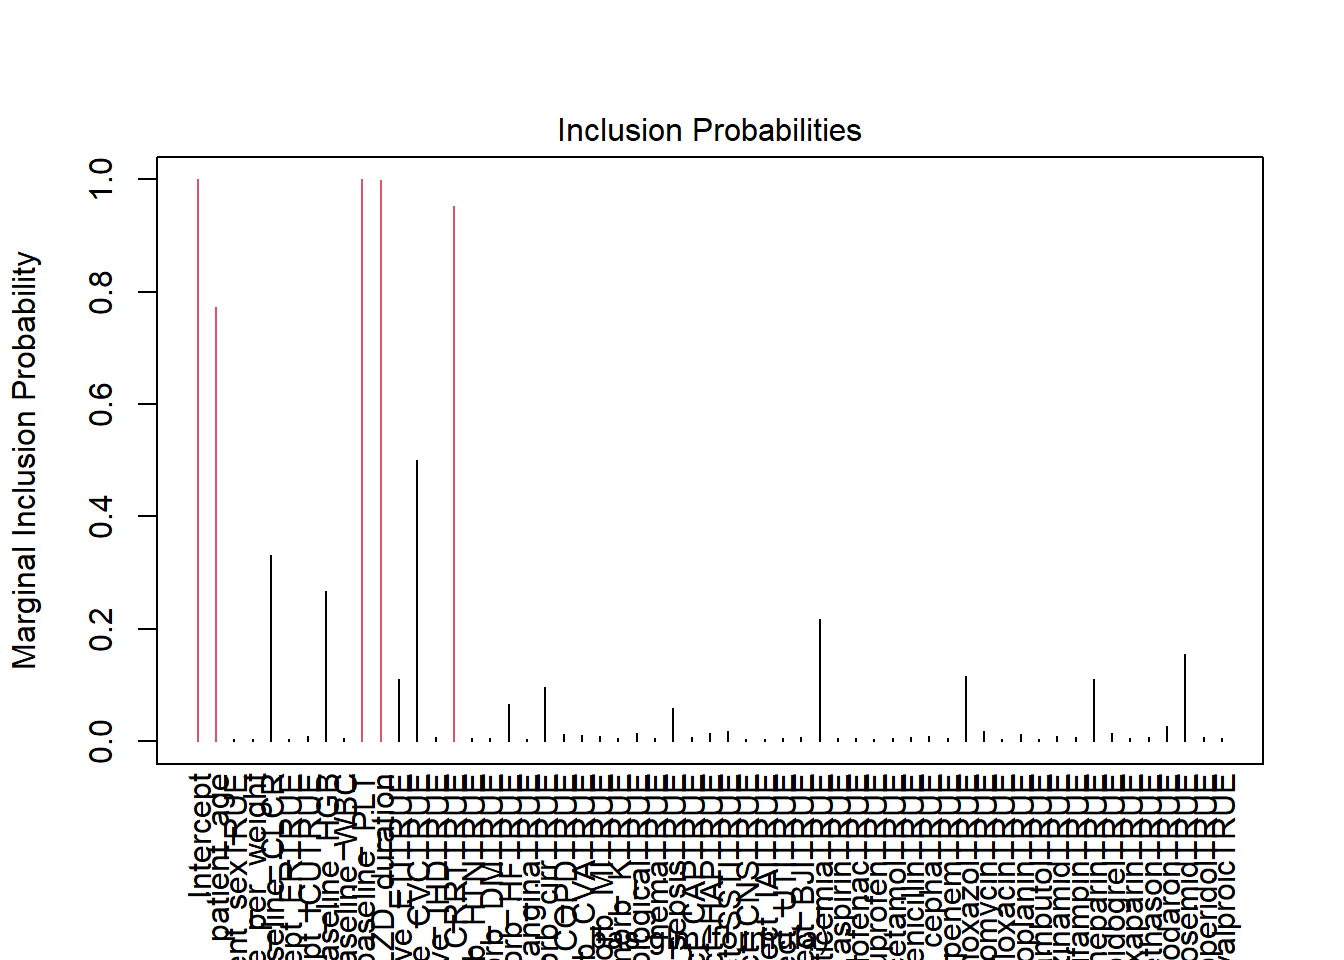

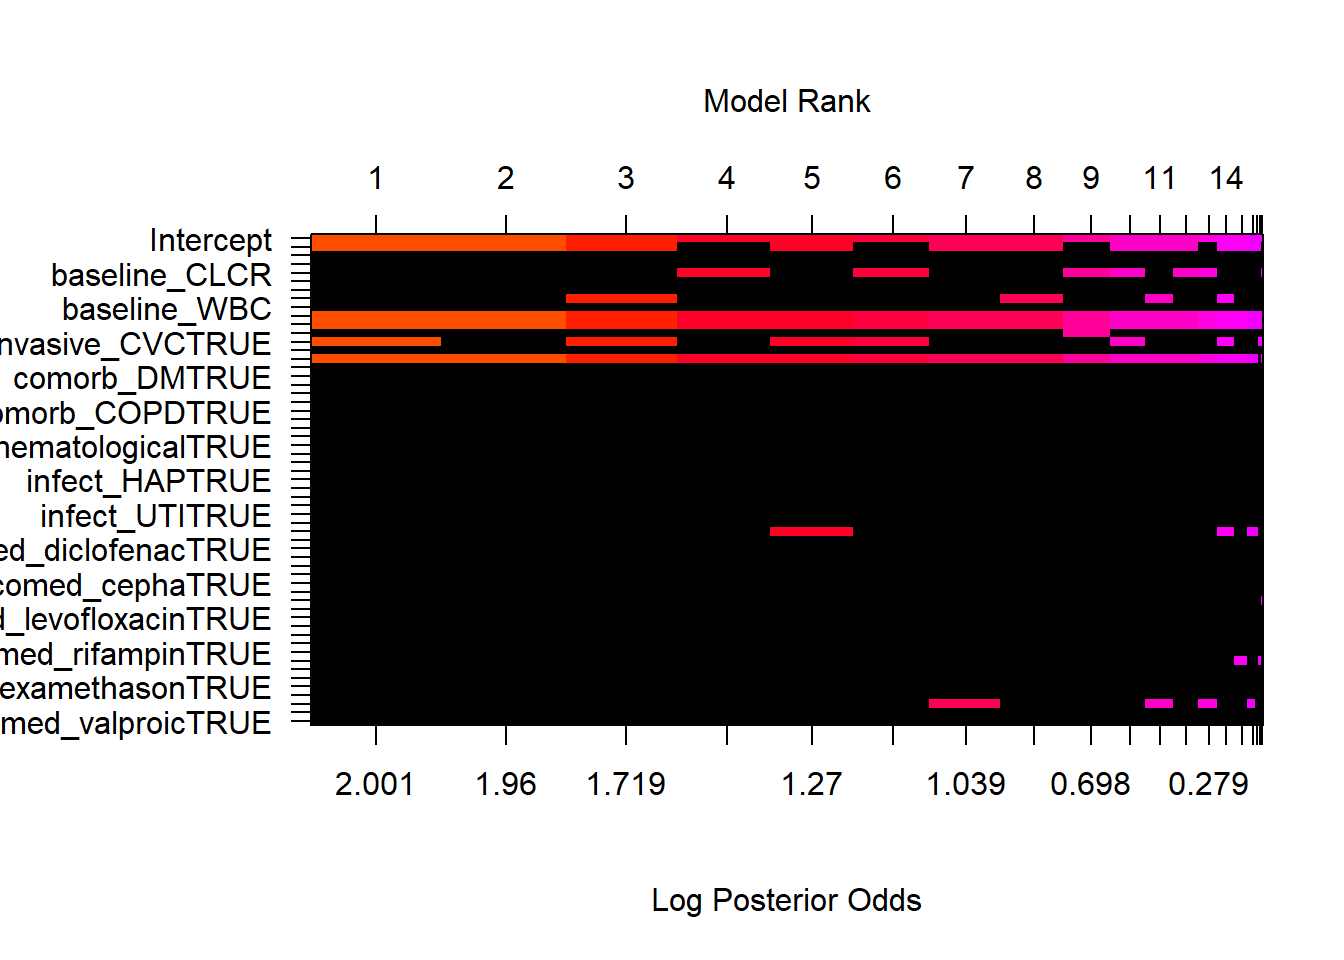

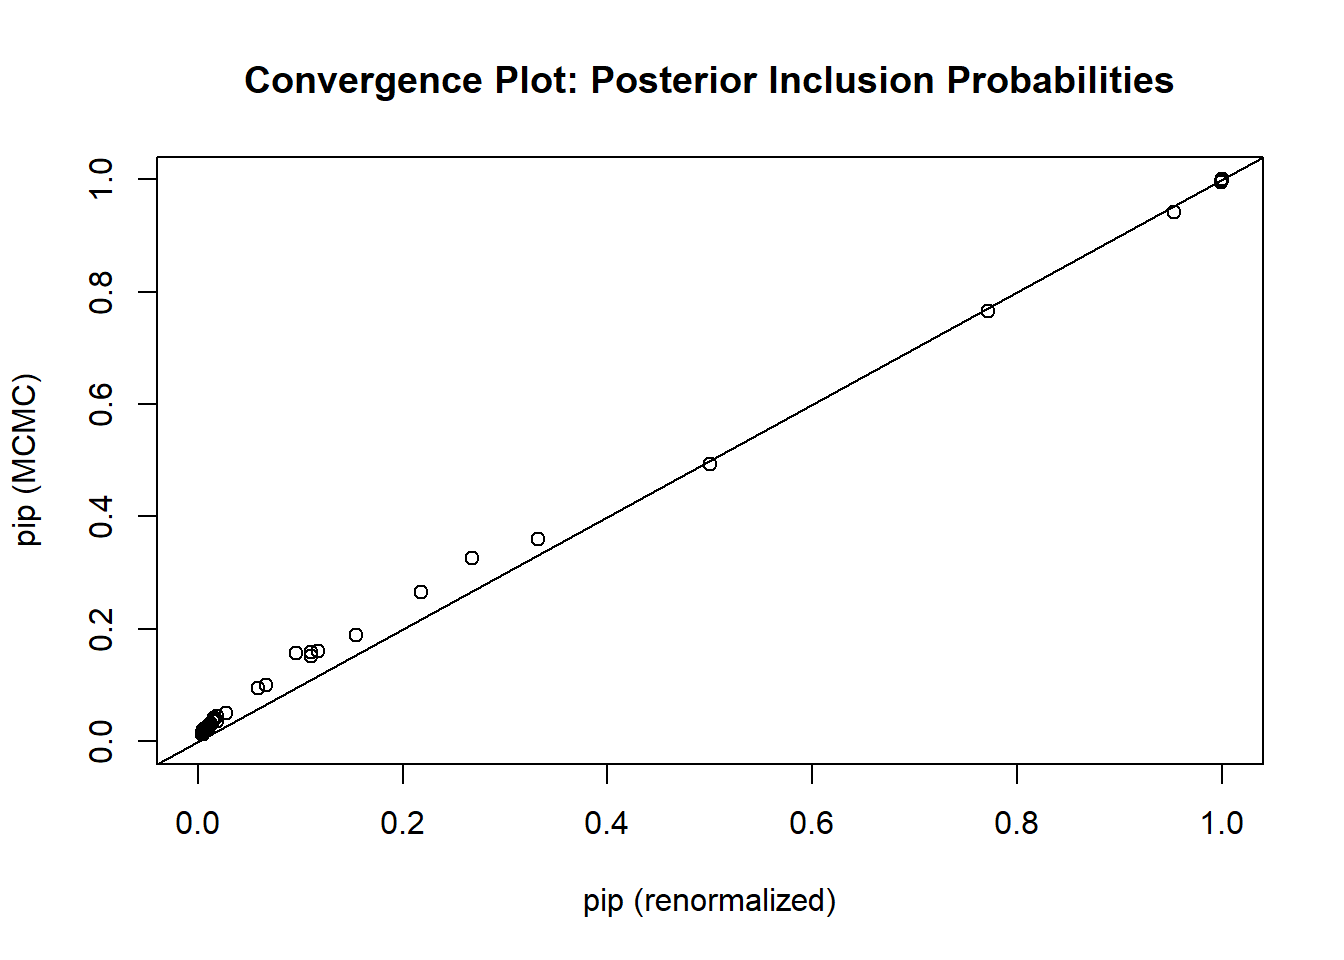

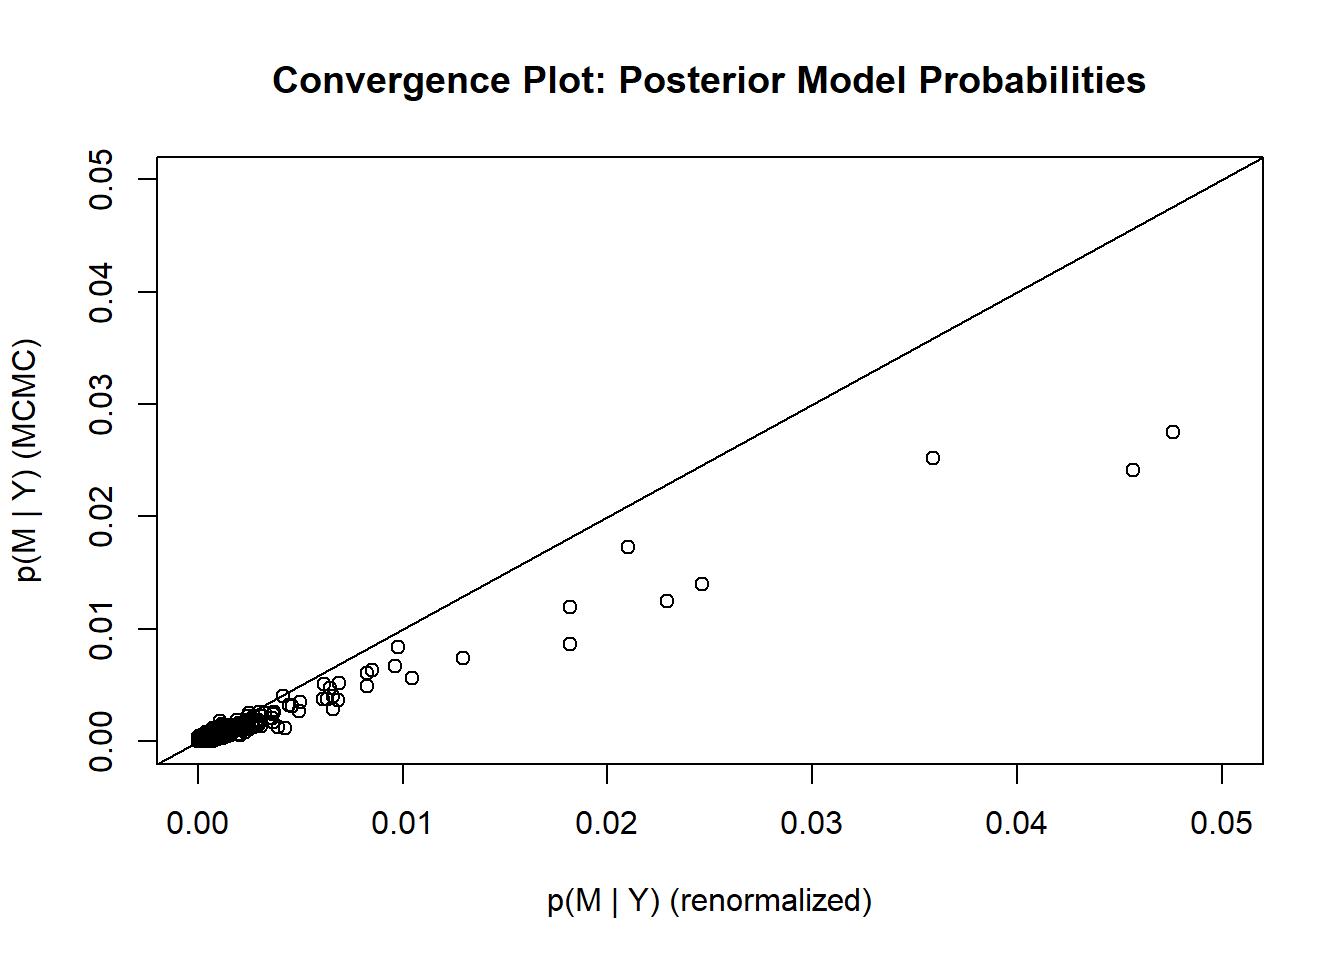

In [ ]:
multi_model <- data_patient_complete |>
  select(all_of(predictor_list), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .
  )

summary(multi_model)


In [ ]:
library(tidymodels)


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5      ✔ rsample      1.2.0 
✔ dials        1.2.1      ✔ tune         1.1.2 
✔ infer        1.0.6      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.0.1 
✔ parsnip      1.2.0      ✔ yardstick    1.3.0 
✔ recipes      1.0.10     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ Matrix::expand()  masks tidyr::expand()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ Matrix::pack()    masks tidyr::pack()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
✖ Matrix::unpack()  masks tidyr::unpack()
✖ recipes::update() masks Matrix::update(), stats::update()
• Use suppressPackageStartupMessages() to eliminate package startup messages

# Check Model Assumptions

## Linearity

Visual check of linearity assumption using partial-residual plots (component+residual plots).

Blue dashed line: linear fit of the partial residuals.

Red line: smoothed conditional mean

The lines should be close together and the red line should be linear.

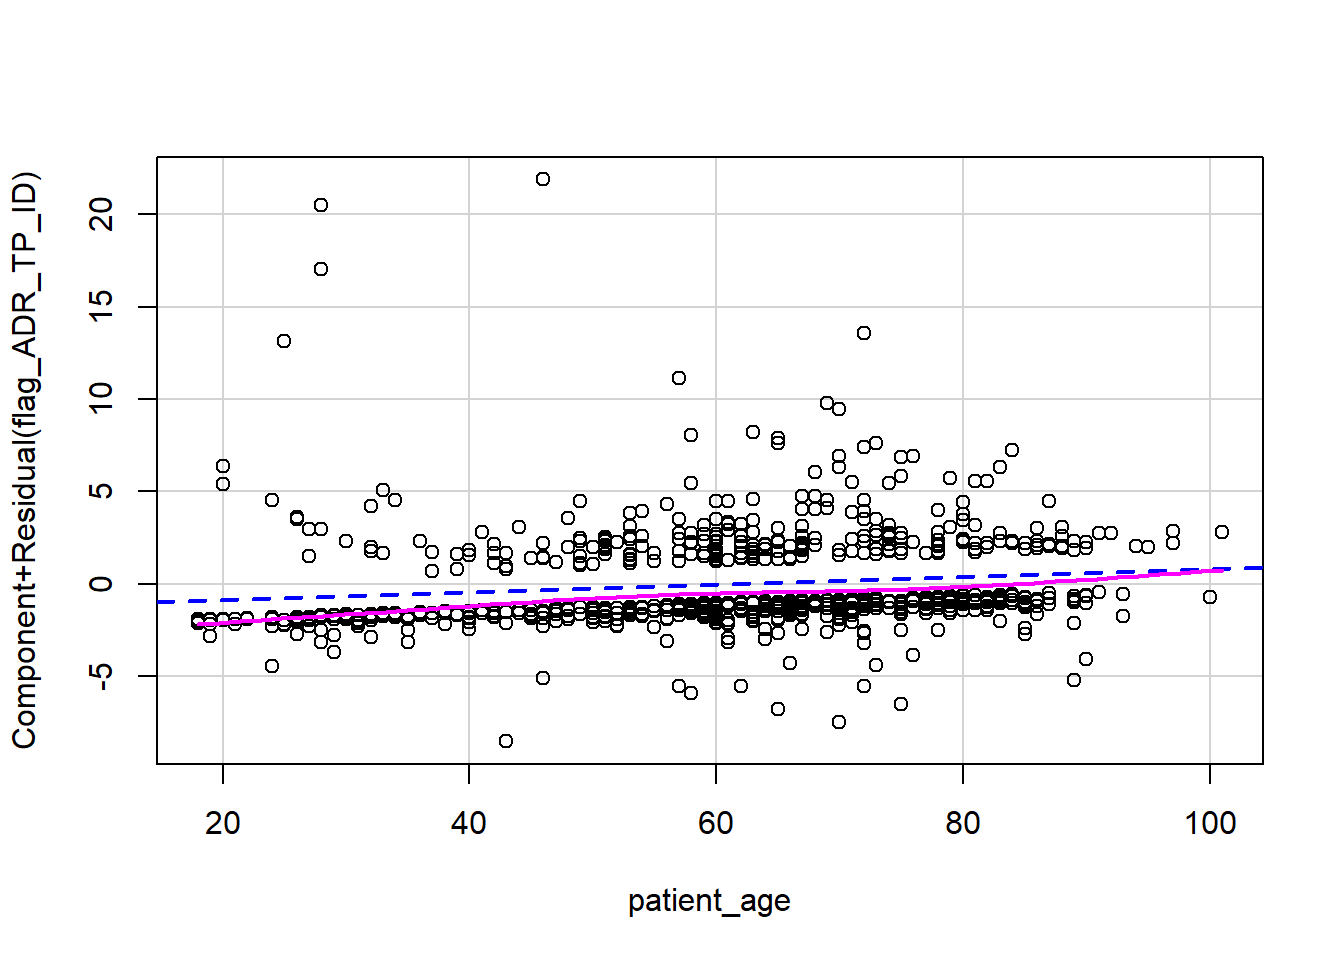

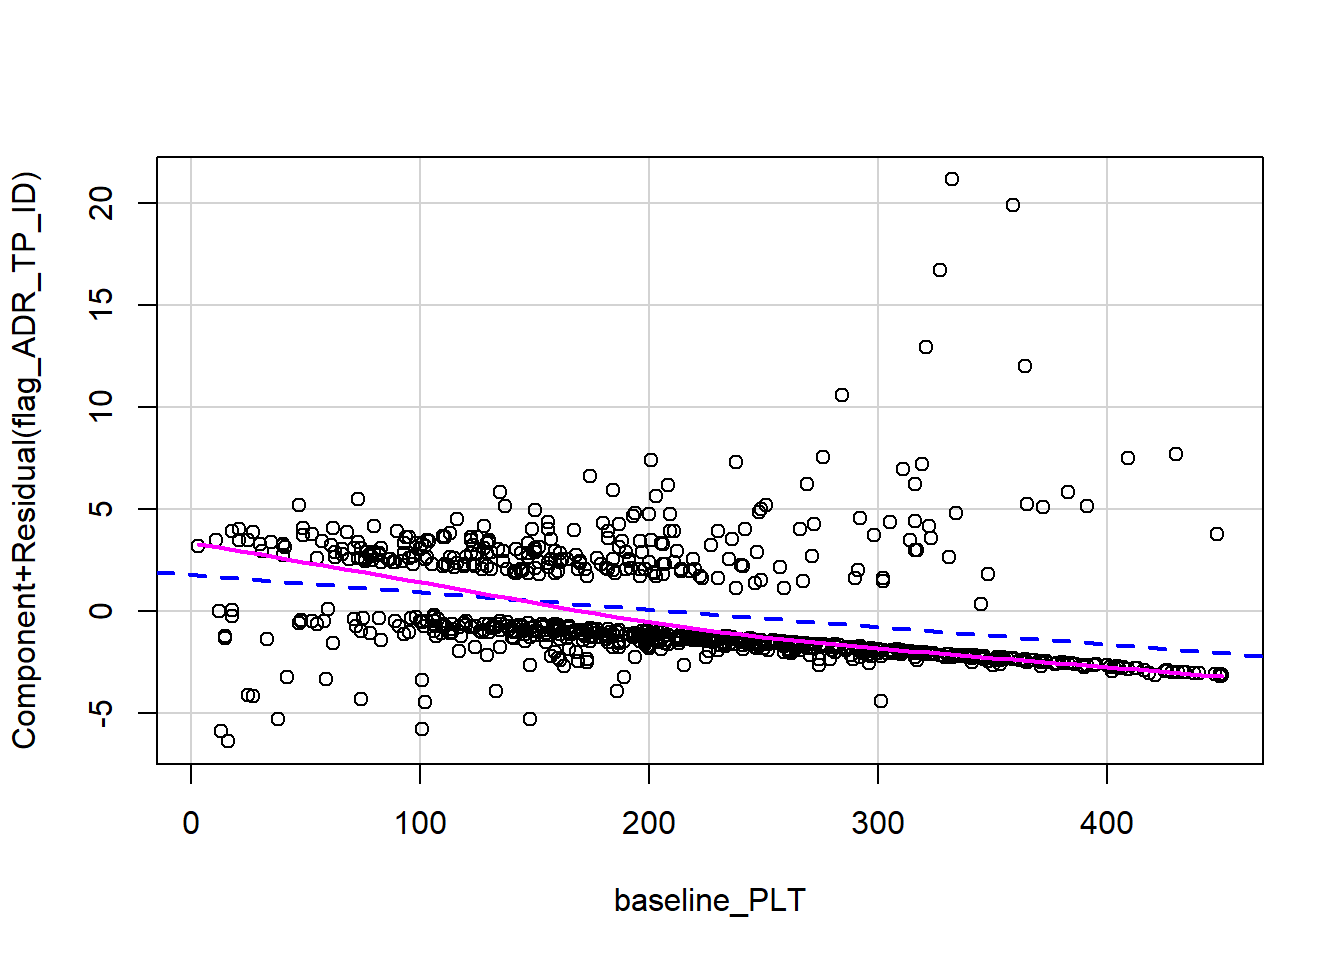

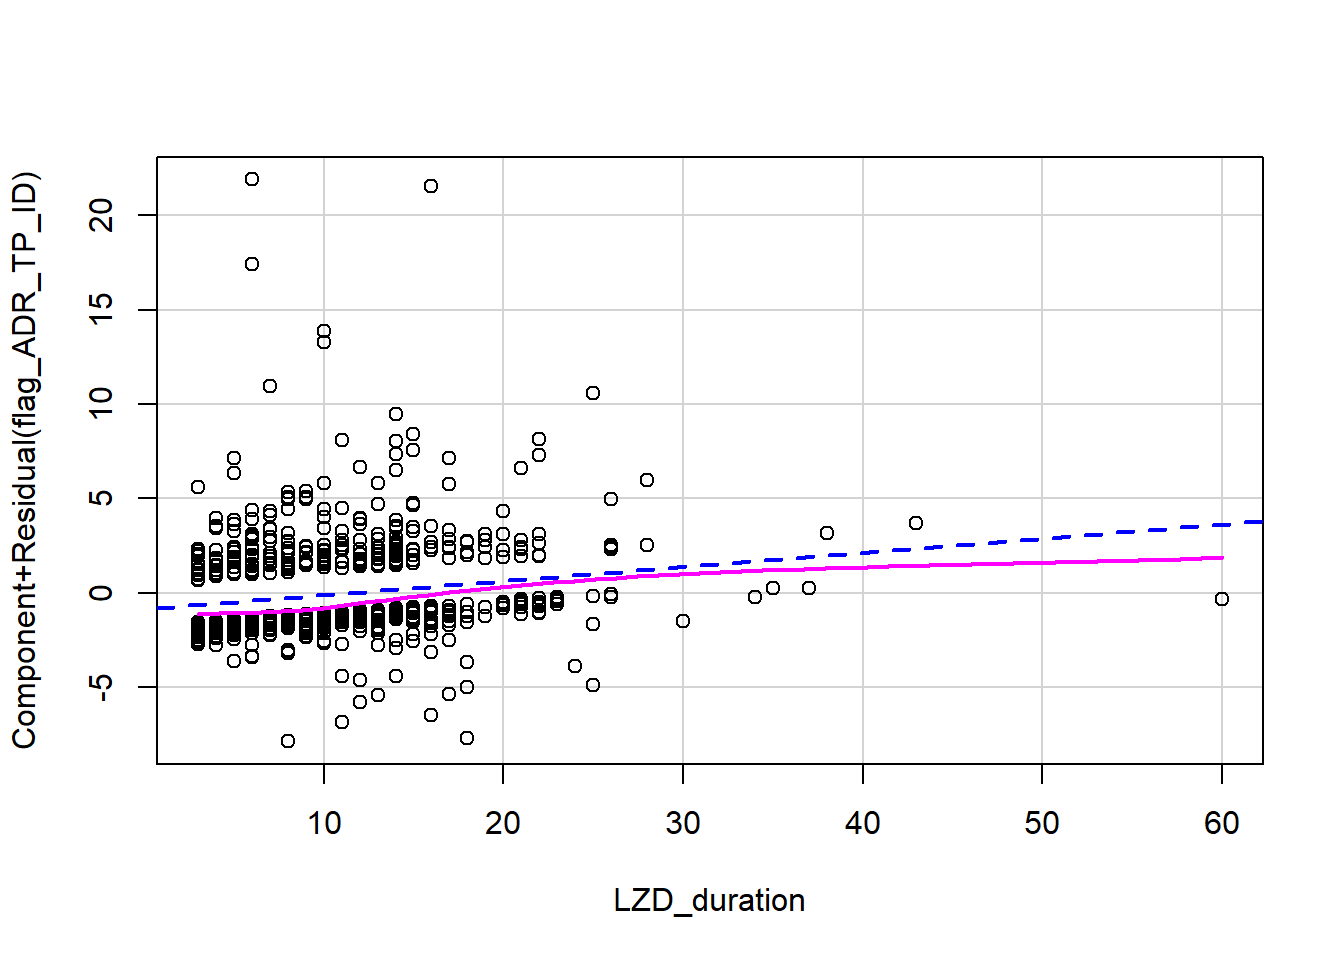

In [ ]:
car::crPlot(model_full$fit, variable = "patient_age")


Result: No obvious non-linearity in the partial-residual plots.

## No Multicollinearity

VIFs from the coefficient estimates should be less than 5 and as close to 1 as possible.

In [ ]:
car::vif(model_full$fit)


  patient_age  baseline_PLT  LZD_duration  invasive_CVC invasive_CRRT 
     1.037139      1.084343      1.092748      1.134306      1.129945 

Result: VIFs are all less than 5 and close to 1.

## No Outlier Effects

Visual check from influence plot.

Individual observations should not have too much influence on the model.

Influence plot:

-   x-axis: Extreme values (Hat-values)
-   y-axis: Leverage (Studentized residuals)
-   Size of points: Cook’s distance

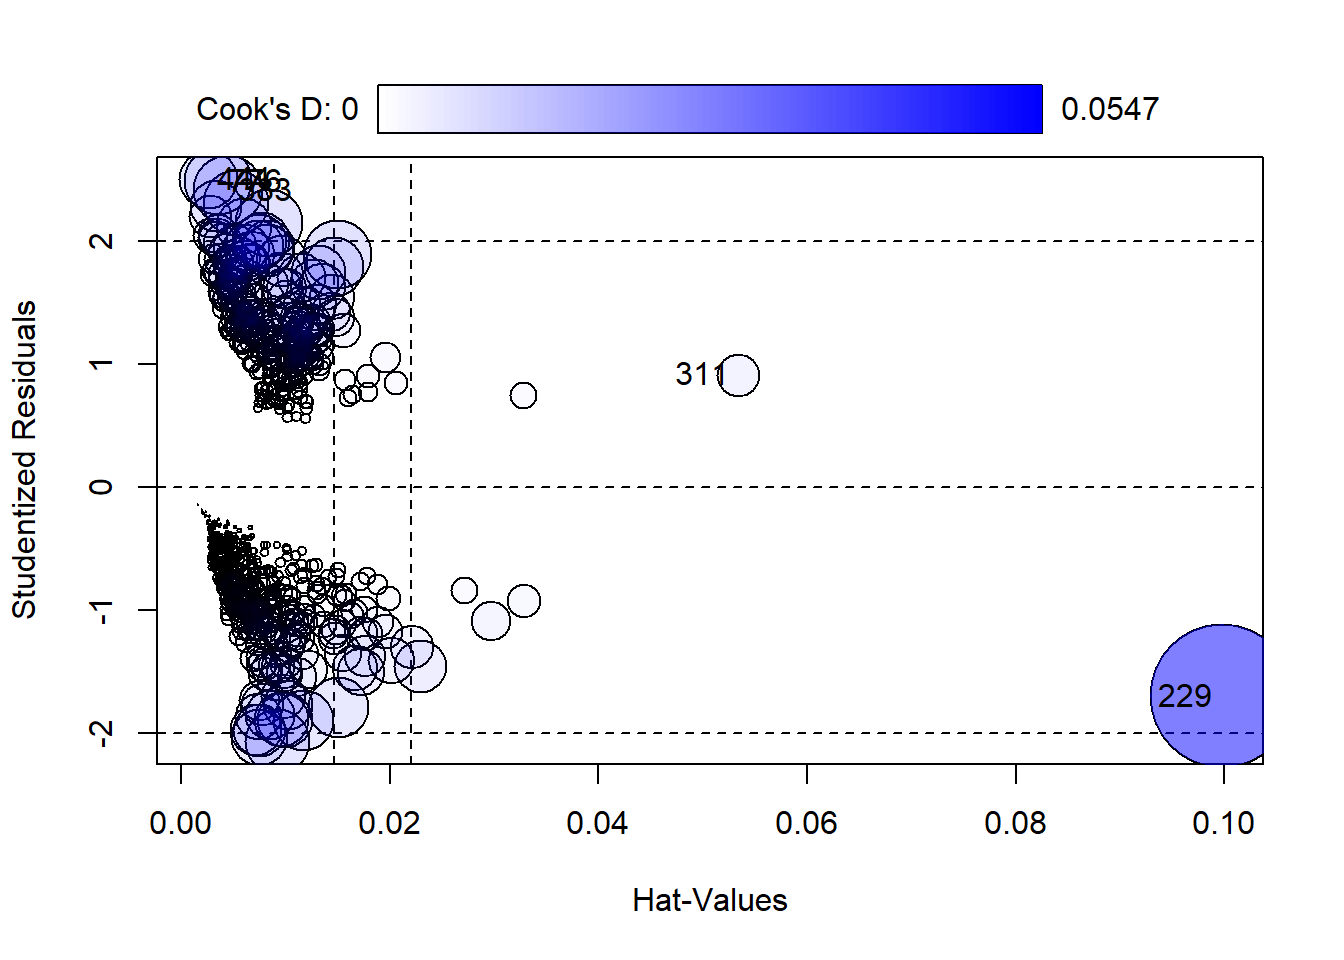

       StudRes         Hat       CookD
229 -1.7010809 0.099758647 0.054695665
311  0.9145756 0.053405034 0.004947532
383  2.4136612 0.004532242 0.012746728
444  2.5010404 0.002591404 0.009203643
776  2.4860403 0.003576678 0.012127386

In [ ]:
car::influencePlot(model_full$fit)


Result: Influential observations identified.

DONE: Investigate observations 292, 301, 335, 364, 504, 634.

Investigation result:

-   invasive_CVC: 5/6
-   comed_furosemid: 3/6
-   infect_septicemia: 3/6

invasive_CVC might be a predictor.

In [ ]:
# data_patient_complete |>
#   slice(c(292, 301, 335, 364, 504, 634)) |> summary()


# Model Performance

In [ ]:
library(CalibrationCurves)


Loading required package: rms

Loading required package: Hmisc


Attaching package: 'Hmisc'

The following object is masked from 'package:parsnip':

    translate

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units

In [ ]:
save(model_full, file = "data/model-performance/model-full.rda")
